In [1]:
%matplotlib inline
import collections
import datetime

import numpy as np
import pandas as pd
import requests

from matplotlib import pyplot as plt
plt.style.use('blog') # Comment this to re-run yourself

API_ENDPOINT = "http://elections.huffingtonpost.com/pollster/api/polls"

np.random.seed(2016)

In [2]:
def get_all_results(state='US', party='gop', start_date='2015-6-1'):
    topic = '2016-president-{}-primary'.format(party)
    params = {'state': state,
              'after': start_date,
              'topic': topic
             }
    page = 1
    while True:
        params['page'] = page
        page_results = requests.get(API_ENDPOINT,
                                    params=params).json()
        for poll in page_results:
            subpop = next(i['subpopulations'][0]
                          for i in poll['questions']
                          if i['topic'] == topic)
            for response in subpop['responses']:
                if response['first_name']:
                    yield {'poll': poll['id'],
                           'date': poll['end_date'],
                           'filter': subpop['name'].lower(),
                           'obs': subpop['observations'],
                           'candidate': '{} {}'.format(response['first_name'], response['last_name']),
                           'mean': response['value']}

        if len(page_results) < 10:
            break
        page += 1

In [3]:
def get_polls(state='US', party='gop', start_date='2015-6-1'):
    polls = pd.DataFrame(get_all_results(state=state, party=party, start_date=start_date))
    polls['date'] = pd.to_datetime(polls['date'])
    return polls


In [4]:
def get_distribution_for_date(polls, target_date=None, window=10):
    if target_date is None:
        target_date = datetime.datetime.today()
    polls = polls[
        (polls['date'] <= target_date)
    ]
    polls = polls[polls['poll'].isin(polls
                                     .drop_duplicates('poll')
                                     .sort_values('date', ascending=False)
                                     .head(window)
                                     ['poll']
                                    )]
    weights = .5 ** ((target_date - polls['date']) / np.timedelta64(1, 'D')) # Change from previous version!
    weighted = polls[['candidate']].copy()
    weighted['n'] = weights * polls['obs']
    weighted['votes'] = polls['mean'] / 100 * polls['obs'] * weights
    weighted = weighted.groupby('candidate').sum()
    weighted['mean'] = weighted['votes'] / weighted['n']
    weighted['std'] = np.sqrt((weighted['mean'] * (1 - weighted['mean'])) / weighted['n'])
    return weighted[['mean', 'std']].query('mean > 0').copy()

In [5]:
def run_simulation(dists, trials=10000):
    runs = pd.DataFrame(
        [np.random.normal(dists['mean'], dists['std'])
         for i in range(trials)],
        columns=dists.index)
    results = pd.Series(collections.Counter(runs.T.idxmax()))
    return results / results.sum()

In [6]:
def predict(state='us', party='gop', window=10, trials=10000, target_date=None, screen=None, drop=None):
    polls = get_polls(state=state, party=party)
    if screen is not None:
        polls = polls[polls['filter'].str.contains(screen)]
    if drop is not None:
        polls= polls[~polls['candidate'].isin(set(drop))]
    dists = get_distribution_for_date(polls, window=window, target_date=target_date)
    print('Superpoll Results:')
    print(dists.sort_values('mean', ascending=False).applymap(lambda x: '{:.1%}'.format(x)))
    print()
    print('Simulation Results:')
    print(run_simulation(dists, trials=trials).sort_values(ascending=False).map(lambda x: '{:.1%}'.format(x)))

In [7]:
def graph(state='us', party='gop', screen=None, drop=None,
          window=10, lag=30, enddate=None):
    # Note: Pollster doesn't seem to care, but I should cache this
    polls = get_polls(state=state, party=party)
    if screen is not None:
        polls = polls[polls['filter'].str.contains(screen)]
    if enddate is None:
        enddate = datetime.datetime.today()
    startdate = enddate - datetime.timedelta(lag)
    
    historical = []
    for i in pd.date_range(polls['date'].min(), enddate):
        historical.append(
            get_distribution_for_date(polls, i, window=window)
            .reset_index()
            .assign(date=i)
        )
    historical = pd.concat(historical).set_index(['candidate', 'date'])

    fig, ax = plt.subplots()
    cycler = (i for i in plt.rcParams['axes.prop_cycle'])
    candidates  = (historical
                   .assign(minval=historical['mean'] - 2 * historical['std'])
                   .xs(max(historical.index.get_level_values('date')), level='date')
                   .query('minval > 0')
                   .sort_values('mean', ascending=False)
                  ).index
    if drop is not None:
        candidates = [i for i in candidates if i not in set(drop)]
    for candidate in candidates:
        candidate_df = historical.xs(candidate).loc[startdate: enddate]
        color = next(cycler)['color']
        ax.plot(candidate_df.index, candidate_df['mean'], color=color, lw=3, label=candidate)
        ax.fill_between(candidate_df.index,
                        (candidate_df['mean'] - 2 * candidate_df['std']).apply(lambda x: max(x, 0)),
                        candidate_df['mean'] + 2 * candidate_df['std'],
                        color=color,
                        alpha=0.25)
    ax.set_ybound(0)
    ax.set_yticks(ax.get_yticks()[1:])
    ax.set_yticklabels("{:.0%}".format(i) for i in ax.get_yticks())
    ax.xaxis.tick_bottom() #NB: This will *finally* be in matplotlibrc in 2.0
    ax.yaxis.tick_left()
    ax.legend(ncol=4, loc='upper center', fontsize='medium')
    fig.set_size_inches(12, 8)
    fig.autofmt_xdate()
    return fig, ax

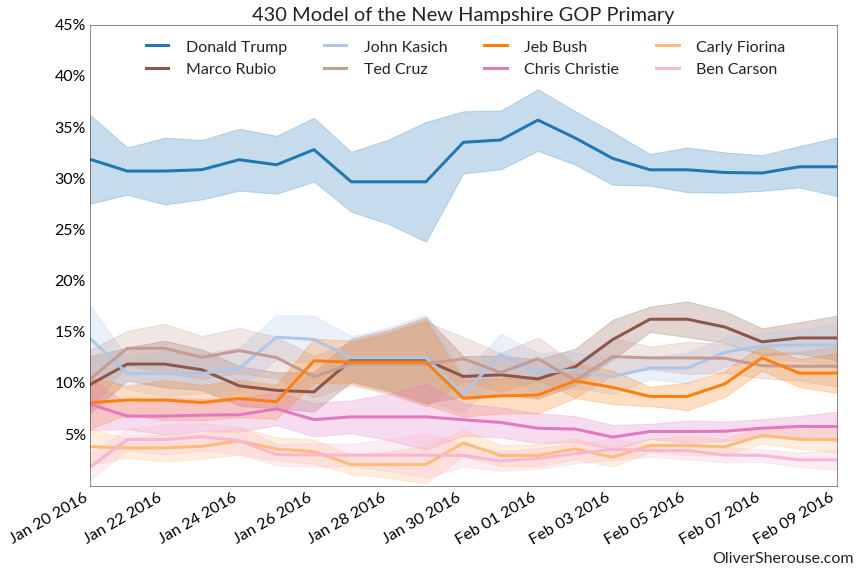

In [8]:
fig, ax = graph(state='nh', party='gop', screen='likely', lag=21,
                drop=('Rand Paul', 'Rick Santorum', 'Jim Gilmore'))
ax.set_title("430 Model of the New Hampshire GOP Primary")
fig.text(1, 0, "OliverSherouse.com", va='bottom', ha='right')
fig.tight_layout()
fig.savefig('nh-gop')

In [9]:
predict(party='gop', state='nh', drop=('Rand Paul', 'Rick Santorum', 'Jim Gilmore'))

Superpoll Results:
                 mean   std
candidate                  
Donald Trump    31.1%  1.7%
Marco Rubio     14.4%  1.3%
John Kasich     13.7%  1.2%
Ted Cruz        11.8%  1.2%
Jeb Bush        11.0%  1.1%
Chris Christie   5.8%  0.8%
Carly Fiorina    4.7%  0.8%
Ben Carson       2.6%  0.6%

Simulation Results:
Donald Trump    100.0%
dtype: object


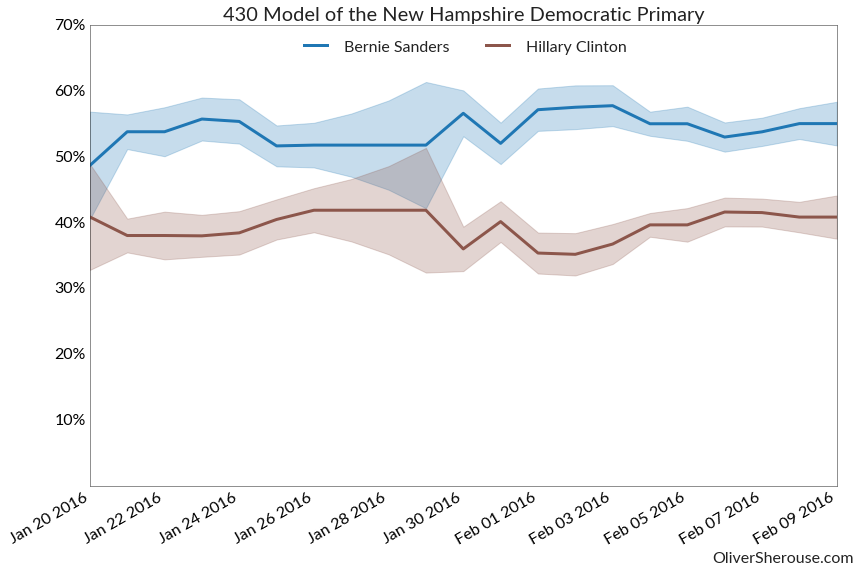

In [10]:
fig, ax = graph(state='nh', party='dem', screen='likely', lag=21,
                drop=('Martin O\'Malley',))
ax.set_title("430 Model of the New Hampshire Democratic Primary")
fig.text(1, 0, "OliverSherouse.com", va='bottom', ha='right')
fig.tight_layout()
fig.savefig('nh-dem')

In [11]:
predict(party='dem', state='nh', drop=("Martin O\'Malley",))

Superpoll Results:
                  mean   std
candidate                   
Bernie Sanders   55.1%  1.9%
Hillary Clinton  40.9%  1.9%

Simulation Results:
Bernie Sanders    100.0%
dtype: object
